<a href="https://colab.research.google.com/github/olcaykursun/ML/blob/main/Spring25/word_embeddings_and_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Gensim: a library for working with pretrained word embeddings like Word2Vec and FastText.
!pip install gensim

# These models convert words into high-dimensional vectors that capture semantic relationships.
# They're trained on large corpora to learn how words co-occur in context.


# --- Word2Vec: Google News (300 dimensions) ---
# ~100 billion words, ~3 million unique words/phrases
# Uncomment to load (large: ~3GB, requires internet):
# from gensim.downloader import load
# w2v = load('word2vec-google-news-300')


# --- FastText: Wiki News + Common Crawl (300 dimensions) ---
# ~16 million documents, ~600 billion tokens, ~1 million words
# Supports out-of-vocabulary words using subword information
# Uncomment to load (smaller: ~1GB, requires internet):
# from gensim.downloader import load
# ft = load('fasttext-wiki-news-subwords-300')



# For something more interactive on word embeddings, you can visit https://projector.tensorflow.org/


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# Sometimes installing a new package like gensim requires a restart for it to be properly imported.
import os
os.kill(os.getpid(), 9)  #it will showed "session is crashed for unknown reason" etc, and yes it looks dramatic — but it works. 😄

In [ ]:
# Load pre-trained FastText model
import gensim.downloader as api
wv = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


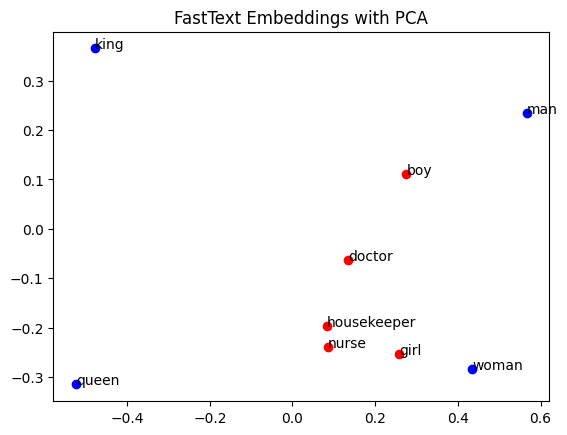

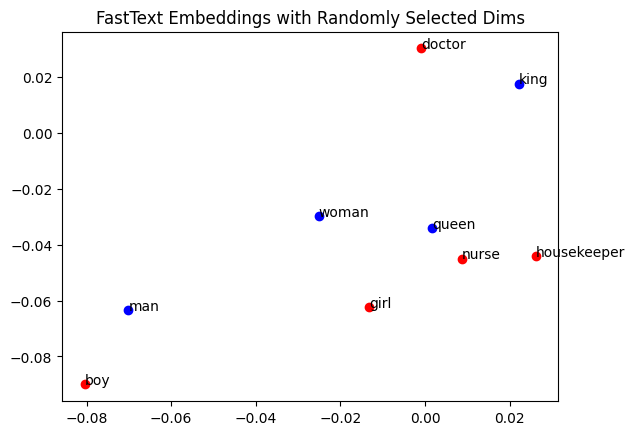

In [ ]:
# FastText Embedding Visualization with PCA
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


# Word lists
train_words = ['king', 'man', 'woman', 'queen']
test_words = ['nurse', 'doctor', 'housekeeper', 'girl', 'boy']
all_words = train_words + test_words

# Embedding matrix
train_matrix = np.array([wv[word] for word in train_words], dtype=np.float32)
test_matrix = np.array([wv[word] for word in test_words], dtype=np.float32)

# --- PCA and Plotting ---
def plot_embeddings_pca(train_matrix, test_matrix, title):
    pca = PCA(n_components=2).fit(train_matrix)
    combined = np.concatenate([train_matrix, test_matrix], axis=0)
    reduced = pca.transform(combined)
    plt.figure()
    plt.title(title)
    for i, word in enumerate(all_words):
        color = 'blue' if word in train_words else 'red'
        plt.scatter(reduced[i, 0], reduced[i, 1], c=color)
        plt.annotate(word, (reduced[i, 0], reduced[i, 1]))
    plt.show()

# --- Plot using two of the original dimensions ---
def plot_embeddings_random(train_matrix, test_matrix, title):
    dim0, dim1 = np.random.choice(train_matrix.shape[1], size=2, replace=False)
    combined = np.concatenate([train_matrix, test_matrix], axis=0)
    plt.figure()
    plt.title(title)
    for i, word in enumerate(all_words):
        color = 'blue' if word in train_words else 'red'
        plt.scatter(combined[i, dim0], combined[i, dim1], c=color)
        plt.annotate(word, (combined[i, dim0], combined[i, dim1]))
    plt.show()

plot_embeddings_pca(train_matrix, test_matrix, "FastText Embeddings with PCA")
plot_embeddings_random(train_matrix, test_matrix, "FastText Embeddings with Randomly Selected Dims")

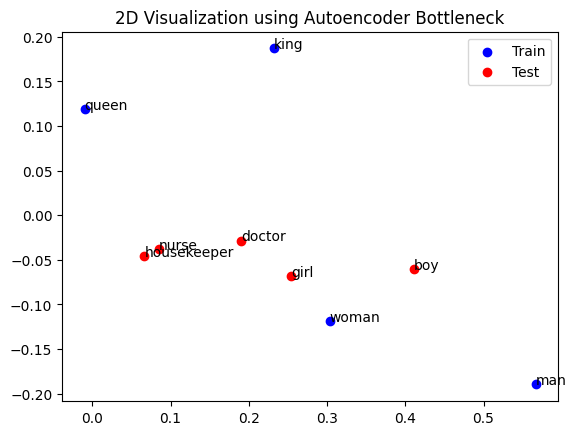

In [ ]:
import torch
import torch.nn as nn

# Word lists
train_words = ['king', 'man', 'woman', 'queen']
test_words = ['nurse', 'doctor', 'housekeeper', 'girl', 'boy']
all_words = train_words + test_words

# Embedding matrix
train_matrix = np.array([wv[word] for word in train_words])
test_matrix = np.array([wv[word] for word in test_words])

train_embeddings = torch.tensor(train_matrix)
test_embeddings = torch.tensor(test_matrix)

# Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim=300, bottleneck_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 100),
            nn.ReLU(),
            nn.Linear(100, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Initialize and train
model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Train only on the train_embeddings
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(train_embeddings)
    loss = criterion(output, train_embeddings)
    loss.backward()
    optimizer.step()

# Get 2D bottleneck outputs
model.eval()
with torch.no_grad():
    train_2d = model.encoder(train_embeddings).numpy()
    test_2d = model.encoder(test_embeddings).numpy()

# Visualization
plt.scatter(train_2d[:, 0], train_2d[:, 1], color='blue', label='Train')
for i, word in enumerate(train_words):
    plt.annotate(word, (train_2d[i, 0], train_2d[i, 1]))

plt.scatter(test_2d[:, 0], test_2d[:, 1], color='red', label='Test')
for i, word in enumerate(test_words):
    plt.annotate(word, (test_2d[i, 0], test_2d[i, 1]))

plt.legend()
plt.title("2D Visualization using Autoencoder Bottleneck")
plt.show()